## COMP90042 Automatic Fact Verification 
----------
    
`1.` [Loading Data](#1)

    1.1 Loading Packages
    1.2 Loading Train, Dev, Test and Filtering Train

`2.` [Pre-processing and Information Retrival](#2)

    2.1 Preprocessor
    2.2 WikiRetriever
    
`3.` [Sentence Selection](#3)
    
    3.1 Word2Vec & Glove
    3.2 Get Top K Sentences

`4.` [Generate Prediction](#4)
    
    4.1 Allennlp Textual Entailment (TE) model
    
`5.` [Evaluation](#4)
    
    5.1 Test Data
    

<a class="anchor" id="1"></a>
## 1. Loading Data
---

### 1.1 Loading Packages

In [12]:
import json, nltk, re, pickle, spacy, string, \
        sys, os, lucene, threading, time, shutil, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from pprint import pprint

from allennlp.predictors.predictor import Predictor
from gensim import models
from gensim.scripts.glove2word2vec import glove2word2vec
import seaborn as sns
from spacy import displacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

from nltk.corpus import stopwords
from collections import defaultdict
from java.util import Arrays
from java.nio.file import Paths

from org.apache.lucene.document import Document, Field, FieldType
from org.apache.lucene.index import \
        FieldInfo, IndexWriter, IndexWriterConfig, IndexOptions, DirectoryReader
from org.apache.lucene.store import SimpleFSDirectory
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.search.similarities import BM25Similarity
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.analysis import \
        LowerCaseFilter, StopFilter, CharArraySet
from org.apache.lucene.analysis.core import StopAnalyzer
from org.apache.lucene.analysis.en import PorterStemFilter
from org.apache.lucene.analysis.standard import \
        StandardTokenizer, StandardFilter
from org.apache.pylucene.analysis import PythonAnalyzer

#!python3 -m spacy download en_core_web_lg # takes about 800M
#!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [84]:
w2v_model = models.KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin.gz', binary=True)

# if not os.path.exists('gensim_glove_vectors.txt'):
#     glove2word2vec(glove_input_file="vectors.txt", word2vec_output_file="gensim_glove_vectors.txt")
# glove_model = models.KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)


lucene.initVM(vmargs=['-Djava.awt.headless=true'])

In [2]:
def custom_tokenizer(nlp):
    infix_re = re.compile(r'''[.\,\?\:\;\...\‘\’\`\“\”\"\'~]''')
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                                suffix_search=suffix_re.search,
                                infix_finditer=infix_re.finditer,
                                token_match=None)

def time_diff(start_time):
    """
    Calculate the time different in secs. Used for testing only.
    :param start_time: the starting time in secs.
    :return: the time different from the start time in secs
    """
    return time.time() - start_time

def print_time(start_time, message):
    """
    Print the time different. It is used for testing
    :param start_time: start time
    :param message: the message to print
    :return: None
    """
    result = time_diff(start_time)
    print(message, ":", '% .6f' % result, 'secs')

def load_pickle(filepath):
    if os.path.getsize(filepath) > 0:
        documents_f = open(filepath, 'rb')
        unpickler = pickle.Unpickler(documents_f)
        file = unpickler.load()
        documents_f.close()
        return file
    else:
        print('Cannot load: ', filepath)

def save_pickle(data, filepath):
    save_documents = open(filepath, 'wb')
    pickle.dump(data, save_documents)
    save_documents.close()
    

%matplotlib inline
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'

spacy_nlp = spacy.load("en_core_web_lg")
spacy_nlp.tokenizer = custom_tokenizer(spacy_nlp)

stp = [word for word in list(stopwords.words('english') + [ "'s", "'m", "ca"])
        if word not in ["no", "not"] and word.rfind("n't") == -1] # stopword list exclude not n't 

### 1.2 Loading Train, Dev, Test and Filtering Train

In [3]:
# Data in JSON format
training_json_data = None
development_json_data = None
testing_json_data = None

def load_data():
    global training_json_data, development_json_data, testing_json_data
    with open('train.json') as json_data:
        training_json_data = json.load(json_data)        
    with open('devset.json') as json_data:
        development_json_data = json.load(json_data)
    with open('test-unlabelled.json') as json_data:
        testing_json_data = json.load(json_data)

load_data()

# """For querying the training_json_data, specific id must be provided, so we replace id with incremental index"""
training_label = []
for t in training_json_data:
    question = {}
    question['id']= t
    question['claim']=training_json_data[t]['claim']
    question['label']=training_json_data[t]['label']
    #print(training_json_data[t]['evidence'])
    if len(training_json_data[t]['evidence'])>1:
        support = []
        for i in range(len(training_json_data[t]['evidence'])):
              #print(training_json_data[t]['evidence'][i])
              support.append(training_json_data[t]['evidence'][i])
        question['evidence']=support
    else:
        question['evidence']=training_json_data[t]['evidence']
    training_label.append(question)

development_label = []

for t in development_json_data:
    question = {}
    question['id']= t
    question['claim']=development_json_data[t]['claim']
    question['label']=development_json_data[t]['label']
    if len(development_json_data[t]['evidence'])>1:
        support = []
        for i in range(len(development_json_data[t]['evidence'])):
            support.append(development_json_data[t]['evidence'][i])
        question['evidence']=support
    else:
        question['evidence']=development_json_data[t]['evidence']
    development_label.append(question)

test_label = []

for t in testing_json_data:
    question = {}
    question['id']= t
    question['claim']=testing_json_data[t]['claim']
    test_label.append(question)

In [40]:
print(training_label[1]['evidence'])

[['Roman_Atwood', 1], ['Roman_Atwood', 3], ['Roman_Atwood', 0], ['Roman_Atwood', 4], ['Roman_Atwood', 2], ['Comedian', 5]]


<a id='2'></a>
## 2. Pre-processing and Informaiton Retrival
---

### 2.1 Preprocessor

In [99]:
class PreProcessor(object):
    '''Pre-processor which cleans text, lemmatises, removes stop words and punctuation, 
    returns df of processed text.'''

    def __init__(self):
        self._stopWordList = stp
        self._punct_removal = list(string.punctuation) + ["--", "---", "-LRB-", "-RRB-"]
        self._word_pattern = r"(?u)\b\w\w+\b"
        self._label_dict = {'SUPPORTS': 1,
                             'REFUTES': 2,
                             'NOT ENOUGH INFO': 3
                           }
        

    def _tokenize_text(self, sample):
        '''tokenises sentences in order to lemmatise, remove stop words and punctuation, 
        returns string of processed text
        Example:
        The following are not (aren't) the football -LRB- soccer -RRB- events of the year 1928 throughout the world .

        follow not football soccer event year 1928 throughout world
        '''

        # get tokens using spacy
        tokens = spacy_nlp(sample)

        # lemmatising tokens
        
#         tokens = [t.lemma_.strip()
#                   if t.lemma_ != "-PRON-"
#                   else t.lower_
#                   for t in tokens]
        
        tokens = [t.lemma_.strip()
                  for t in tokens]

        # stopword and punctuation removal
        tokens = [t.lower() for t in tokens
                  if (t not in self._stopWordList and t not in self._punct_removal)]

        processed_text = " ".join(tokens)

        return processed_text
    

    def get_noun_chunks(self, sentence):
        return [x.text for x in spacy_nlp(sentence).noun_chunks]
    
    def get_ents(self, sentence):
        return [x.text for x in spacy_nlp(sentence).ents]
    
    def spacy_visualize(self, sentence):
        displacy.render(nlp(sentence), jupyter=True, style='ent')
        displacy.render(nlp(sentence), style='dep', jupyter = True, options = {'distance': 100})
    
    
    def transform_text(self, data, filename):
        '''applies the clean and tokenise methods to the texts, 
        encodes the target variable to numerical. 
        Option to set pickle to True to save clean df'''
        
        data['c_claim'] = data['claim'].apply(lambda row: self._tokenize_text(row))
        data['ner'] = data['claim'].apply(lambda row: self.get_ents(row))
        data['noun_chunks'] = data['claim'].apply(lambda row: self.get_noun_chunks(row))  
        if 'label' in data.columns:
            data['label'] = data['label'].apply(lambda row: self._label_dict[row])
        
        
        if not os.path.exists('pickle_data'):
            os.mkdir('pickle_data')
        save_pickle(data, os.path.join('pickle_data',filename + '.p'))


In [4]:
"""For each instance, we apply preprocess by convert the dictionary stucture into dataframe"""
test = pd.DataFrame.from_dict(testing_json_data)
train = pd.DataFrame.from_dict(training_label)
develop = pd.DataFrame.from_dict(development_json_data)
# del test_label, training_label, development_label

In [108]:
cost_time = time.time()
preprocessor = PreProcessor()
# if not os.path.exists('pickle_data/clean_dev.p'):
#     preprocessor.transform_text(develop, 'clean_dev')
if not os.path.exists('pickle_data/clean_test.p'):
    preprocessor.transform_text(test, 'clean_test')
if not os.path.exists('pickle_data/clean_train.p'):
    preprocessor.transform_text(train, 'clean_train')
print_time(cost_time,"Processing Time")

Processing Time :  0.006335 secs


In [5]:
dataTrain = load_pickle('pickle_data/clean_train.p')
# dataDev = load_pickle('pickle_data/clean_dev.p')
dataTest = load_pickle('pickle_data/clean_test.p')
# del test, train, develop

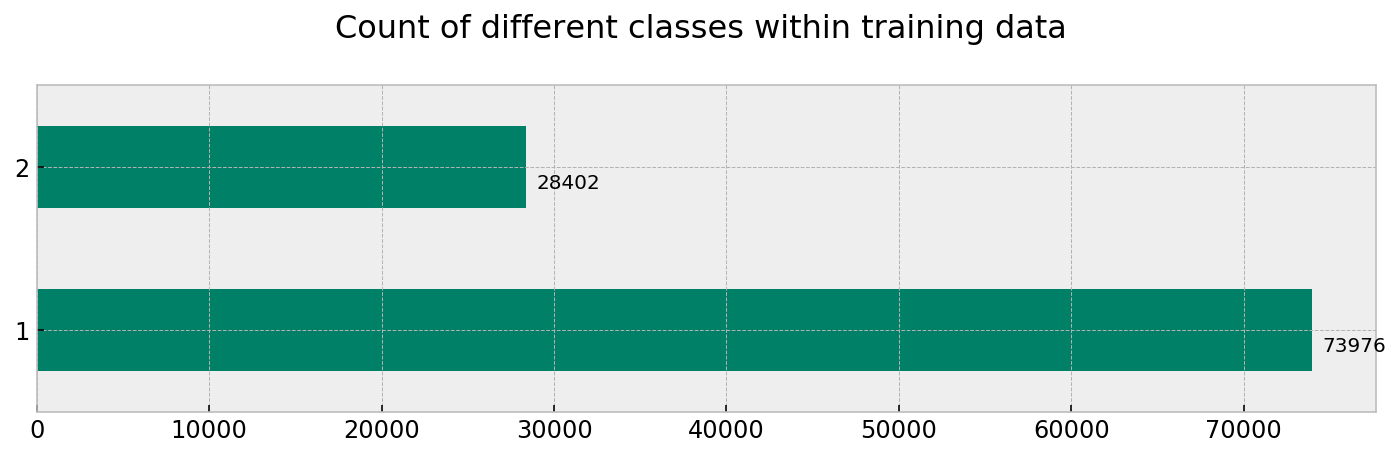

In [20]:
ax=dataTrain.label.value_counts().plot(kind='barh', figsize=(12,3), fontsize=12, cmap='summer')
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.title('Count of different classes within training data \n', size=16)
plt.show()

1.0


Text(0.5, 1.0, 'Evidence Frequence')

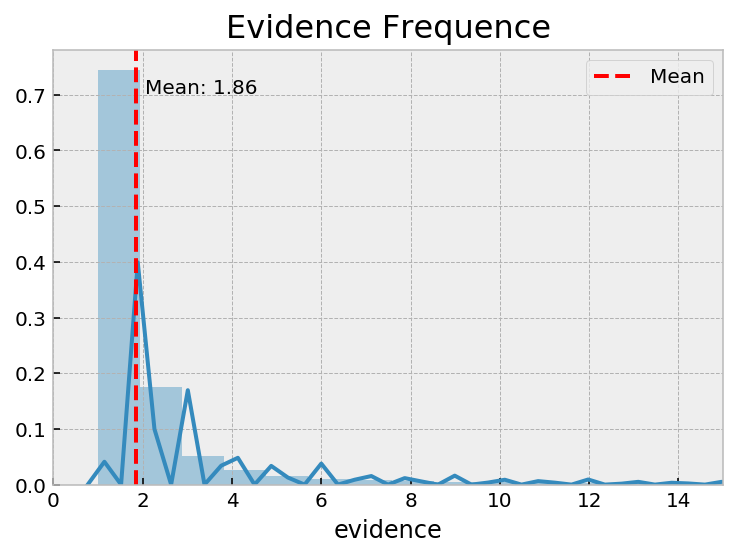

In [62]:
ax = train[train['evidence'].str.len()!=0]
evidence = ax['evidence'].str.len()
#print(evidence.value_counts())
ax1=sns.distplot(evidence)
mean = ax['evidence'].str.len().mean()
median = ax['evidence'].str.len().median()
print(mode)
plt.xlim(0, 15)
ax1.axvline(mean, color='r', linestyle='--')
plt.legend({'Mean':mean})
_, max_ = plt.ylim()
plt.text(evidence.mean() + evidence.mean()/10, 
         max_ - max_/10, 
         'Mean: {:.2f}'.format(evidence.mean()))
plt.title('Evidence Frequence', size=16)
#plt.savefig("output.png",dpi=1000)


### 2.2 WikiRetriever

In [85]:
class WikiAnalyzer(PythonAnalyzer):

    def createComponents(self, fieldName):
        """Custome stopwords dataset including not aren't isn't ...
        """
        source = StandardTokenizer()
        filter = StandardFilter(source)
        filter = LowerCaseFilter(filter)
        filter = StopFilter(filter, CharArraySet(Arrays.asList(stp),False))
#         filter = PorterStemFilter(filter)
    
        
        return self.TokenStreamComponents(source, filter)

    def initReader(self, fieldName, reader):
        return reader

class WikiRetriever(object):
    def __init__(self):
#         env.attachCurrentThread()
        self._indexdir = 'pylucene.index'
        self._wikidir = 'wiki-pages-text'
        
        self._store = SimpleFSDirectory(Paths.get(self._indexdir))
#         self._analyzer = StandardAnalyzer()
        self._analyzer = WikiAnalyzer()
        
        self._clearIndex(clear=False)

        
    def _clearIndex(self,clear=True):
        if clear:
            if os.path.exists(self._indexdir):
                shutil.rmtree(self._indexdir)
            os.mkdir(self._indexdir)
            self._add_doc()
        
        self._searcher = IndexSearcher(DirectoryReader.open(self._store))
        self._searcher.setSimilarity(BM25Similarity())
    
    def _add_doc(self):
        config = IndexWriterConfig(self._analyzer)
        config.setOpenMode(IndexWriterConfig.OpenMode.CREATE)
        writer = IndexWriter(self._store, config)
        
        t1 = FieldType()  
        t1.setStored(False)
        t1.setTokenized(True)
        t1.setIndexOptions(IndexOptions.DOCS)
        
        t2 = FieldType()
        t2.setStored(True)
        t2.setTokenized(False)
        t2.setIndexOptions(IndexOptions.DOCS)
        
        filepaths = glob.glob(os.path.join(self._wikidir, '*'))
        for path in filepaths:
            with open(path,'r') as f:
                file = path.split("/")[1]
                title, sentid, content = f.readline().split(' ',2)
                prev_title, doc, contents = title, Document(), ''
                f.seek(0)
                for line in f:
                    title, sentid, content = line.split(' ',2)
                    if sentid.isdigit():
                        if title != prev_title:
                            doc.add(Field("contents",contents, t1))
                            doc.add(Field("title",prev_title, t2))
                            doc.add(Field("filename",file, t2))
                            writer.addDocument(doc)
                            prev_title, doc, contents = title, Document(), ''
                        contents = contents + content
                doc.add(Field("contents",contents, t1))
                doc.add(Field("title",prev_title, t2))
                doc.add(Field("filename",file, t2))
                writer.addDocument(doc) 
            writer.commit()
        writer.close()
        
        
    def _find_possible_title(self, command):
        texts = spacy_nlp(command)
        results, temp, propn_distance = [], [], 9999
        for i,x in enumerate(texts):
            if x.pos_ == 'PROPN':
                temp.append(x)
                propn_distance = 0
            elif propn_distance < 1:
                temp.append(x)
                propn_distance += 1
            elif propn_distance == 1:
                results.append(temp)
                temp = []
                propn_distance = 9999
        if temp != []:
            results.append(temp)
            
        for i,x in enumerate(texts):
            if x.pos_ == 'PROPN':
                temp.append(x)
            else:
                results.append(temp)
                temp = []
        if temp != []:
            results.append(temp)

        for m in results:
            for n in reversed(m):
                if n.pos_ == 'PROPN':
                    break
                else:
                    m.pop()
        for i,x in enumerate(results):
            results[i] = [y.text for y in x]
        results = ['_'.join(x) for x in results]
        results = [x.replace(' ', '_') for x in results]
        results = [x for x in results if x != '']
        return list(set(results))        
        
    
    def ir_search(self, command, num_results=1):
        '''Search docs as much as possible
        
        RETURN: ir_results: list(Document)
        USE: ir_results[i].get("title")
                          .get("filename") 
        '''
        ir_results, temp_results, maxnum, no_poss_title = [], [], 10000, True
        possible_title = self._find_possible_title(command)
        
        query = QueryParser("contents", self._analyzer).parse(command)
        results = self._searcher.search(query, maxnum).scoreDocs
#         print('Query: ', query)
#         print('Possible Title (Extract from query): ', possible_title)
#         print('--------------------------------------------------')
        
        for i,hit in enumerate(results):
            doc = self._searcher.doc(hit.doc)
            
            if doc.get("title") in possible_title and possible_title != []:
                no_poss_title = False
                temp_results.append(doc)
#                 print('Found potential doc in {}. FILE: {}  DOC: {}' \
#                       .format(str(i), doc.get("filename"), doc.get("title")))
            
            if no_poss_title and i < num_results:
                ir_results.append(doc)
        
        if not no_poss_title:
            no_poss_title = False
            ir_results = temp_results[:]
        
        return ir_results, no_poss_title
            
    def ir_get_content(self,what_file, what_title):
        with open(os.path.join('wiki-pages-text', what_file), 'r') as f:
            results = {}
            for line in f:
                if line == "":
                    continue 
                t, sent_id, content = line.split(' ',2)
                if t == what_title:
                    content = content.replace("-LRB-","(")
                    content = content.replace("-RRB-",")")
                    content = content.replace("-LSB-","[")
                    content = content.replace("-RSB-","]")
                    content = content.replace("-SLH-", "/")
                    content = content.replace("-COLON-", ":")
                    content = content.replace("\n","")
                    results[sent_id] = content
            return results
            

In [86]:
atime= time.time()
aw = WikiRetriever()
print_time(atime,"Building Time")

Building Time :  0.278650 secs


In [62]:
query = "Derek Hough starred in an American film"
aw.ir_search(query)

([<Document: Document<stored,indexed,tokenized,indexOptions=DOCS<title:Derek_Hough> stored,indexed,tokenized,indexOptions=DOCS<filename:wiki-027.txt>>>],
 False)

In [61]:
aw._find_possible_title("Derek Hough starred in an American film")

['Derek_Hough']

In [89]:
d= aw.ir_get_content("wiki-027.txt", "Derek_Hough")#12

<a id='3'></a>
## 3. Sentence Selection 
---

### 3.1 Word2Vec & Glove

In [101]:
def word_model(s1, s2, wordmodel):
    if s1 == s2:
        return 1.0
    s1words = s1.split()
    s2words = s2.split()
    s1wordsset = set(s1words)
    s2wordsset = set(s2words)
    vocab = wordmodel.vocab  # the vocabulary considered in the word embeddings
    if len(s1wordsset & s2wordsset) == 0:
        return 0.0
    for word in s1wordsset.copy():  # remove sentence words not found in the vocab
        if word not in vocab:
            s1wordsset.remove(word)
    for word in s2wordsset.copy():  # idem
        if word not in vocab:
            s2wordsset.remove(word)
    
    if not (len(s1wordsset) and len(s2wordsset)):
        return 0.0
    else:
        return wordmodel.n_similarity(s1wordsset, s2wordsset)


def most_relevant_w(sentence1, ir_content, model):
    score = {}
    sentence = {}
    score_=[]
    test = False
    for k, v in ir_content.items():
        score[k] = word_model(preprocessor._tokenize_text(sentence1), preprocessor._tokenize_text(v), model)
        sentence[int(k)] = v
    for v in sorted(score.values(), reverse=True):
        if v!=0.0:
            score_.append(v)
    #print(score)
    if len(score_)==0:
        return sorted(score.items(), key=lambda kv:(kv[1], kv[0]), reverse=True)[:1], sentence
    else:
#         diff = [j-i for i, j in zip(score_[:-1], score_[1:])]
        diff1= []
        
        for i in range(1, len(score_)):
            diff1.append(score_[i]-score_[0])
        #print(diff1)
        for i in range(len(diff1)):
            if abs(diff1[i])<=0.201:
                test = True
                break
        #print(diff1, top1)
#         for i in range(len(diff)):
#             if abs(diff[i]) < 0.2:
#                 top.add(i)
#                 top.add(i+1)
        if test:
            return  sorted(score.items(), key=lambda kv:(kv[1], kv[0]), reverse=True)[:2], sentence
        else:
            return sorted(score.items(), key=lambda kv:(kv[1], kv[0]), reverse=True)[:1], sentence
    
def most_relevant_avg(sentence1, ir_content):
    score = {}
    score_=[]
    sentence = {}
    test = False
#     top = set()
#     top1=set()
    NER=pass_all(sentence1, ir_content)
    #print("sdfasdf")
    #print(NER)
    for k, v in ir_content.items():
        #if k in NER:
            sum_tot = word_model(preprocessor._tokenize_text(sentence1), preprocessor._tokenize_text(v), glove_model)\
                + word_model(preprocessor._tokenize_text(sentence1), preprocessor._tokenize_text(v), w2v_model)
            score[k] = sum_tot
            sentence[int(k)] = v
    
    for v in sorted(score.values(), reverse=True):
        if v!=0.0:
            score_.append(v)
    #print(score)
    if len(score_)==0:
        return sorted(score.items(), key=lambda kv:(kv[1], kv[0]), reverse=True)[:1], sentence
    else:
#         diff = [j-i for i, j in zip(score_[:-1], score_[1:])]
        diff1= []
        
        for i in range(1, len(score_)):
            diff1.append(score_[i]-score_[0])
        #print(diff1)
        for i in range(len(diff1)):
            if abs(diff1[i])<=0.201:
                test = True
                break
        #print(diff1, top1)
#         for i in range(len(diff)):
#             if abs(diff[i]) < 0.2:
#                 top.add(i)
#                 top.add(i+1)
        if test:
            return  sorted(score.items(), key=lambda kv:(kv[1], kv[0]), reverse=True)[:2], sentence
        else:
            return sorted(score.items(), key=lambda kv:(kv[1], kv[0]), reverse=True)[:1], sentence





In [103]:
def test_NER(claim, ir_content):
    unique_NER=set()
    for ent in spacy_nlp(claim).ents:
        unique_NER.add(ent.label_)
    
    NER1={}
    for k, v in ir_content.items():
        w1=spacy_nlp(v)
        NER = set()
        for ent in w1.ents:
            NER.add(ent.label_)
        NER1[k]=NER
#     print(unique_NER)
#     print(NER1)
    answer = {}
    for k, v in NER1.items():
        if unique_NER <= v:
            answer[k]='y'
        else:
            answer[k]='n'
#     print(answer)
    return answer

def pass_all(claim, ir_content):
    all_pass=[]
    for k,v in test_NER(claim, ir_content).items():
        if v=='y':
            all_pass.append(k)
    return all_pass

def output(claim, ir_content):
    test, sentence = most_relevant_avg(claim, ir_content)
    pass_tag = pass_all(claim, ir_content)
    for k, v in test.copy():
        #print(k, v)
        if k not in pass_tag:
            test.remove((k, v))
    return test, sentence

In [104]:
def get_topk_results(temps, topk):
    results = []
    while topk > 0:
        max_score, max_sentence, max_resultid = 0, 0, 0
        for i, temp in enumerate(temps):
            for j, s in enumerate(temp['sent_score']):
                if s[1] > max_score:
                    max_score = s[1]
                    max_sentence = s[0]
                    max_resultid = i
                    temps[i]['sent_score'][j] = (s[0], 0)
    
        results.append([max_resultid, max_sentence, max_score])
        topk -= 1
        
    return results

def sentence_select(claim, model):
    ir_results, no_poss_title = aw.ir_search(claim)
    #print(ir_results)
    docK = len(ir_results) if not no_poss_title else 1
    temp_list, evi_list, sentences_list = [], [], []
    for i, doc in enumerate(ir_results):
        retri_doc = aw.ir_get_content(doc.get("filename"),doc.get("title"))
        temp_list.append({})
        sentences = {}
        
        if retri_doc == {}:
            docK -= 1
            temp_list[i]['sent_score'] = [(-1,-1)]
            sentences_list.append(sentences)
            continue
            
        if model == 'g':
            sent_score, sentences = most_relevant_w(claim, retri_doc, glove_model)
        
        elif model == 'w':
            sent_score, sentences = most_relevant_w(claim, retri_doc, w2v_model)
        elif model == 'a':
            sent_score, sentences = most_relevant_avg(claim, retri_doc)
        temp_list[i]['sent_score'] = sent_score
        sentences_list.append(sentences)
        
    
    if sentences == {}:
        return []
    
    topk_results = get_topk_results(temps=temp_list, topk=len(sent_score))
    
    for i, result in enumerate(topk_results):
        evi_list.append({})
        r_id, s_id = int(result[0]), int(result[1])
        evi_list[i]['doc'] = ir_results[r_id].get("title")
        evi_list[i]['filename'] = ir_results[r_id].get("filename")
        evi_list[i]['sent_id'] = s_id
        evi_list[i]['sentence'] = sentences_list[r_id][s_id]
        evi_list[i]['sim_score'] = result[2]
    
    return evi_list

### 3.2 Get Top _K_ Sentences

In [109]:
atime = time.time()
evi_list = sentence_select(train['claim'].values[10], "w")
print(evi_list)
print_time(atime, 'Time')

[{'doc': 'Tetris', 'filename': 'wiki-094.txt', 'sent_id': 18, 'sentence': 'In January 2010 , it was announced that the Tetris franchise had sold more than 170 million copies , approximately 70 million physical copies and over 100 million copies for cell phones , making it the best selling paid-downloaded game of all time .', 'sim_score': 0.7738719532574108}]
Time :  0.760935 secs


<a id='4'></a>
## 4. Generate Prediction
---

### 4.1 Allennlp Textual Entailment (TE) model

In [110]:
te_model = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/decomposable-attention-elmo-2018.02.19.tar.gz")

Did not use initialization regex that was passed: .*token_embedder_tokens\._projection.*weight


In [111]:
def te_predict(hypothesis, premise):
    result = te_model.predict(
        hypothesis=hypothesis,
        premise=premise
    )
    max_prob = max(result['label_probs'])
    max_index = result['label_probs'].index(max_prob)
    if max_index == 0:
        return "SUPPORTS", max_prob
    elif max_index == 1:
        return "REFUTES", max_prob
    else:
        return "NOT ENOUGH INFO", max_prob

In [26]:
#     max_prob = max(result['label_probs'][:2])
#     max_index = result['label_probs'].index(max_prob)
#     if max_index == 0:
#         return "SUPPORTS", max_prob
#     else:
#         return "REFUTES", max_prob

<a id='5'></a>
## 5. Evaluation
---

### 5.1 Test Data

In [115]:
def multi_process_eva(input_info):
    atime=time.time()
    filename, s_model = input_info[0], input_info[1]
    
    with open(filename, "r+") as jsonFile:
        write_data = json.load(jsonFile)
        line_num = 0
        for line_id in write_data:
            test_claim = write_data[line_id]['claim']
            test_claim = test_claim.replace("\"","")
            test_claim = test_claim.replace("/"," ")
            label_list, evidences = [], []
            most_label = "NOT ENOUGH INFO"

            evi_list = sentence_select(test_claim, s_model)
            if evi_list != []:
                for i, evi in enumerate(evi_list):
                    label, prob = te_predict(hypothesis=test_claim, premise = evi['sentence'])
                    label_list.append(label)
                    evi_list[i]['label'] = label
                    evi_list[i]['te_score'] = prob

                most_label = Counter(label_list).most_common(1)[0][0]

            # update test.json
            if most_label == "NOT ENOUGH INFO":
                write_data[line_id]['label'] = most_label
                write_data[line_id]['evidence'] = []
            else:
                write_data[line_id]['label'] = most_label
                for evi in evi_list:
                    if evi['label'] == most_label:
                        temp_evi = [evi['doc'],evi['sent_id']]
                        evidences.append(temp_evi)
                write_data[line_id]['evidence'] = evidences

            jsonFile.seek(0)  # rewind
            json.dump(write_data, jsonFile, indent=4)
            jsonFile.truncate()

            if line_num % 1000 == 0:
                print(line_num, end='\t')
                print_time(atime,"Time")
            line_num += 1

    print_time(atime,"Time")

In [116]:
multi_process_eva(('devset_0_500_q.json','w'))

0	Time :  1.902717 secs
Time :  903.724278 secs


In [232]:
!python3 score.py devset_0_500_a.json devset_0_500_q.json

Label Accuracy 		42.14%
Sentence Precision 	43.04%
Sentence Recall 	25.07%
Sentence F1 		31.69%
Document Precision 	58.41%
Document Recall 	33.81%
Document F1 		42.83%


In [187]:
"""First difference better"""
!python3 score.py devset_0_500_a.json devset_0_500_q.json

Label Accuracy 		45.25%
Sentence Precision 	37.93%
Sentence Recall 	31.56%
Sentence F1 		34.45%
Document Precision 	52.21%
Document Recall 	39.60%
Document F1 		45.04%


### 5.2 Dev Data

In [113]:
with open('devset.json','r') as f:
    data = json.load(f)

data_a = defaultdict()
data_q = defaultdict(defaultdict)
line_num = 0
for index in data:
    if line_num > 0 and line_num < 500:
        data_a[index] = data[index]
        data_q[index]['claim'] = data[index]['claim']
    line_num += 1
        
with open('devset_0_500_q.json', 'w') as f1:
    json.dump(data_q, f1)
with open('devset_0_500_a.json', 'w') as f1:
    json.dump(data_a, f1)

In [59]:
!python3 score.py devset_0_500_a.json devset_0_500_q.json

Label Accuracy 		39.88%
Sentence Precision 	33.65%
Sentence Recall 	21.01%
Sentence F1 		25.87%
Document Precision 	51.52%
Document Recall 	37.39%
Document F1 		43.33%


In [201]:
!python3 score.py devset_0_1000_a.json devset_0_1000_q_average.json

Label Accuracy 		44.14%
Sentence Precision 	35.72%
Sentence Recall 	31.74%
Sentence F1 		33.62%
Document Precision 	46.76%
Document Recall 	45.05%
Document F1 		45.89%


In [29]:
!python3 score.py devset_0_1000_a.json devset_0_1000_q_w2v.json

Label Accuracy 		44.94%
Sentence Precision 	41.86%
Sentence Recall 	29.42%
Sentence F1 		34.55%
Document Precision 	53.21%
Document Recall 	40.43%
Document F1 		45.94%


In [35]:
!python3 score.py testoutput.json testoutput.json

Label Accuracy 		100.00%
Sentence Precision 	100.00%
Sentence Recall 	100.00%
Sentence F1 		100.00%
Document Precision 	100.00%
Document Recall 	100.00%
Document F1 		100.00%


In [29]:
!python3 score.py devset_0_500_q.json devset_0_500_a.json

Traceback (most recent call last):
  File "score.py", line 20, in <module>
    alabel = arecord['label'].upper()
KeyError: 'label'


In [117]:
!python3 score.py devset_0_500_a.json devset_0_500_q.json

Label Accuracy 		48.30%
Sentence Precision 	36.68%
Sentence Recall 	29.73%
Sentence F1 		32.84%
Document Precision 	51.28%
Document Recall 	40.46%
Document F1 		45.23%
